## Classificação e Monitoramento de Reviews do leitor digital Kindle

In [167]:
pip install clean-text

Note: you may need to restart the kernel to use updated packages.


In [168]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

import nltk 
from nltk.stem import RSLPStemmer
from nltk.tokenize import word_tokenize
from string import punctuation
from cleantext import clean
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from numpy import array
from numpy import asarray

nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mcacs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\mcacs\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mcacs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [169]:
df = pd.read_csv('reviews_kindle.csv')
df.head()

,Nome,Titulo,Texto,Data,Review
0,Anne Naus,"Mais barato, bom e bonito. Amei minha escolha.","Apesar de oferecer 4GB, só com sistema ele con...",Avaliado no Brasil em 27 de maio de 2019,"5,0 de 5 estrelas"
1,SoldaCosta,Onde está meus 90 dias de leitura grátis?,Adorei. Só não ganhei os 90 dias de leitura gr...,Avaliado no Brasil em 30 de abril de 2019,"4,0 de 5 estrelas"
2,Amanda s,Bom produto,Maravilhoso!Mas ainda estou procurando os 4gb ...,Avaliado no Brasil em 3 de maio de 2019,"4,0 de 5 estrelas"
3,Allison Silva Resende,Triste compra uma coisa que se diz 4gb e so vi...,"Produto é o que é, gostei da experiencia é a p...",Avaliado no Brasil em 6 de maio de 2019,"1,0 de 5 estrelas"
4,Laura Marodin De Bacco,Maravilhoso,Não posso comparar com as outras geração pois ...,Avaliado no Brasil em 4 de maio de 2019,"5,0 de 5 estrelas"


In [170]:
df.shape

(5000, 5)

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Nome    5000 non-null   object
 1   Titulo  5000 non-null   object
 2   Texto   4999 non-null   object
 3   Data    5000 non-null   object
 4   Review  5000 non-null   object
dtypes: object(5)
memory usage: 195.4+ KB


In [172]:
df['Review'] = df['Review'].str.replace('de 5 estrelas', '').str.replace(',0', '')

df["Texto"] = df["Texto"].astype(str)
df["Review"] = df["Review"].astype(int)

In [173]:
df.head()

,Nome,Titulo,Texto,Data,Review
0,Anne Naus,"Mais barato, bom e bonito. Amei minha escolha.","Apesar de oferecer 4GB, só com sistema ele con...",Avaliado no Brasil em 27 de maio de 2019,5
1,SoldaCosta,Onde está meus 90 dias de leitura grátis?,Adorei. Só não ganhei os 90 dias de leitura gr...,Avaliado no Brasil em 30 de abril de 2019,4
2,Amanda s,Bom produto,Maravilhoso!Mas ainda estou procurando os 4gb ...,Avaliado no Brasil em 3 de maio de 2019,4
3,Allison Silva Resende,Triste compra uma coisa que se diz 4gb e so vi...,"Produto é o que é, gostei da experiencia é a p...",Avaliado no Brasil em 6 de maio de 2019,1
4,Laura Marodin De Bacco,Maravilhoso,Não posso comparar com as outras geração pois ...,Avaliado no Brasil em 4 de maio de 2019,5


## Distribuição das Reviews:

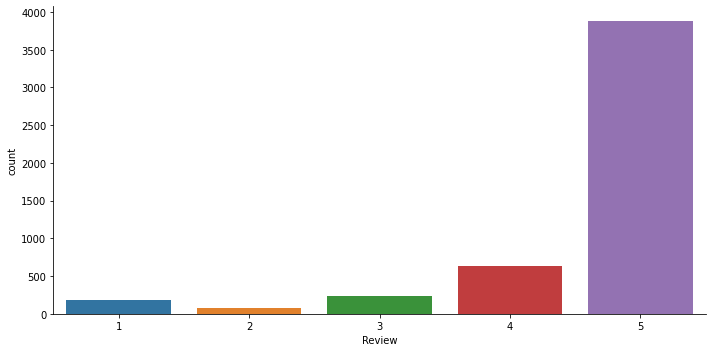

In [174]:
sn.catplot(x='Review', kind='count', data=df, aspect=2)
plt.show()

## Divisão das Reviews entre Negativo (0) e Positivo (1):

In [175]:
df['Review'] = df['Review'].replace([1,2,3,4], 0)
df['Review'] = df['Review'].replace([5], 1)

In [176]:
df.head()

,Nome,Titulo,Texto,Data,Review
0,Anne Naus,"Mais barato, bom e bonito. Amei minha escolha.","Apesar de oferecer 4GB, só com sistema ele con...",Avaliado no Brasil em 27 de maio de 2019,1
1,SoldaCosta,Onde está meus 90 dias de leitura grátis?,Adorei. Só não ganhei os 90 dias de leitura gr...,Avaliado no Brasil em 30 de abril de 2019,0
2,Amanda s,Bom produto,Maravilhoso!Mas ainda estou procurando os 4gb ...,Avaliado no Brasil em 3 de maio de 2019,0
3,Allison Silva Resende,Triste compra uma coisa que se diz 4gb e so vi...,"Produto é o que é, gostei da experiencia é a p...",Avaliado no Brasil em 6 de maio de 2019,0
4,Laura Marodin De Bacco,Maravilhoso,Não posso comparar com as outras geração pois ...,Avaliado no Brasil em 4 de maio de 2019,1


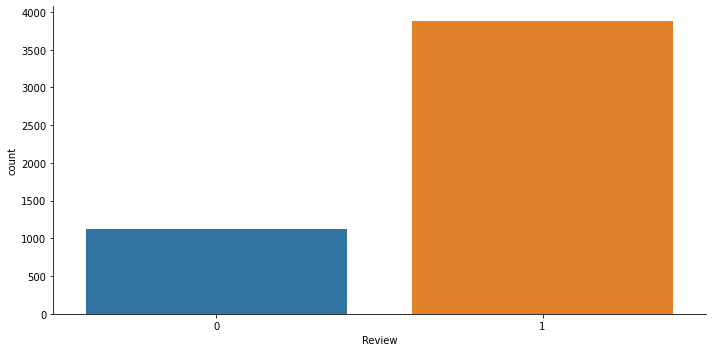

In [177]:
sn.catplot(x='Review', kind='count', data=df, aspect=2)
plt.show()

In [178]:
df["Review"].value_counts()

1    3880
0    1120
Name: Review, dtype: int64

Percebe-se que o dataset é formado principalmente por avaliações positivas. Mais precisamente, 77,6% das avaliações 
são positivas e 22,4% são negativas.
O agrupamento dos reviews foi feito de modo a tentar diminuir ao máximo o desbalanceamento entre as classes.

## Limpeza, Tokenização e Stemming:

In [179]:
df["Tokens"] = df["Texto"]
df["Stemmer"] = df["Texto"]

In [180]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


In [181]:
!python -m spacy download pt_core_news_sm

[+] Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


2022-04-04 22:22:04.102105: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-04 22:22:04.102150: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [182]:
import string
import spacy
import pt_core_news_sm

nlp = pt_core_news_sm.load()

stopwors_spacy = spacy.lang.pt.stop_words.STOP_WORDS
stopwors_nltk = nltk.corpus.stopwords.words('portuguese')
alfabeto = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'w', 'y', 'z']


tokens = []
for i in range(df.shape[0]):
    s = df.loc[i, "Texto"]

    s = s.lower()

    s = remove_emoji(s)

    s = re.sub('kkk*', '', s, flags=re.IGNORECASE)
    s = re.sub('rsr*', '', s, flags=re.IGNORECASE)
    s = re.sub('haha*', '', s, flags=re.IGNORECASE)

    s = s.replace('’', '').replace('‘', '').replace('’’', '').replace('“', '').replace('”', '')
    s = s.replace("'", '').replace('"', '').replace(',', '.')
    
    s = s.replace('!', ' ').replace(':', ' ').replace(';', ' ')
    s = s.replace(')', ' ').replace('(', ' ').replace('±', ' ')
    s = s.replace('/', ' ').replace('\\', ' ').replace('//', ' ')

    s = s.replace('–', ' ').replace('—', ' ').replace('•', ' ')
    s = s.replace('…', ' ').replace('}', ' ').replace('±', ' ')

    s = s.replace('*', ' ').replace('%', ' ').replace('$', ' ')
    s = s.replace('#', ' ').replace('–', ' ').replace('—', ' ')
    s = s.replace('@', ' ').replace('&', ' ')

    s = s.replace('{', ' ').replace('––', ' ').replace('--', ' ')
    
    s = s.replace('<', ' ').replace('?', ' ').replace('`', ' ')
    
    s = s.replace(' gb', 'gb').replace('wiffi', 'wi-fi').replace('wifi', 'wi-fi').replace('w-ifi', 'wi-fi')
    
    s = s.replace('ésuper', 'é super').replace('éé', 'é').replace('è', 'é')
    s = s.replace('ñ', 'não').replace('òtimo', 'ótimo')
    s = s.replace('ótimaaa', 'ótima').replace('ótimasperfeito', 'ótimas perfeito')
    s = s.replace('ótimoo', 'ótimo').replace('ė', 'é').replace('vaaaarios', 'vários')
    s = s.replace('vaaarias', 'várias') .replace('valeeeus', 'valeus').replace('varias', 'várias')
    s = s.replace('varios', 'vários').replace('vc', 'você').replace('vcs', 'vocês').replace('vdd', 'verdade')

    s = s.replace('viagensresolvi', 'viagens resolvi').replace('vidaaa', 'vida').replace('vistaa', 'vista')
    s = s.replace('vocabuláriostradução', 'vocabulários tradução').replace('voce', 'você')
    s = s.replace('voces', 'vocês').replace('vontadesuper', 'vontade super').replace('váaaarios', 'vários')

    s = s.replace('àqueles', 'aqueles').replace('àquilo', 'aquilo').replace('whatssap', 'whatsapp')
    s = s.replace('whhite', 'white').replace('taaanto', 'tanto').replace('tanra', 'tanta').replace('tantoo', 'tanto')
    s = s.replace('tblet', 'tablet').replace('tbm', 'também').replace('td', 'tudo').replace('tdo', 'tudo')
    s = s.replace('tds', 'todos').replace('tecidosuas', 'tecido suas').replace('teconlogia', 'tecnologia')
    s = s.replace('telaenvio', 'tela envio').replace('telapor', 'tela por').replace('telaum', 'tela um')
    s = s.replace('telegran', 'telegram').replace('tenjo', 'tenho').replace('titulos', 'títulos')
    s = s.replace('titulo', 'título').replace('tambem', 'também').replace('tochscreen', 'touchscreen')
    s = s.replace('touch-screen', 'touchscreen').replace('touchscreen', 'touchscreen').replace('touché', 'touch')
    s = s.replace('toucshscreen', 'touchscreen').replace('toutch', 'touch')

    s = s.replace('traqnuilamente', 'tranquilamente').replace('tristeos', 'triste os').replace('tristetem', 'triste tem')
    s = s.replace('tudooo', 'tudo').replace('uahuashusah', '').replace('ulimited', 'unlimited')
    s = s.replace('táctil', 'tátil').replace('ulinmited', 'unlimited').replace('ullimited', 'unlimited')
    s = s.replace('umaleitura', 'uma eitura').replace('ume', 'um e').replace('umlimited', 'unlimited')
    s = s.replace('ummês', 'um mês').replace('umsmartphone', 'um smartphone').replace('univeidade', 'universidade')
    s = s.replace('univeitário', 'universitário').replace('univeitários', 'universitários').replace('unilimed', 'unlimited')
    s = s.replace('unilimites', 'unlimiteds').replace('unimited', 'unlimited').replace('unlimeted', 'unlimited')
    s = s.replace('unlimitade', 'unlimited').replace('unlmited', 'unlimited').replace('up-grade', 'upgrade')
    s = s.replace('usar-ló', 'usá-lo').replace('usuario', 'usuário').replace('usuárioo', 'usuário')
    s = s.replace('usá-lousei', 'usá-lo usei').replace('utilizaçãodesign', 'utilização design')
    s = s.replace('utilizalo', 'utiliza-lo').replace('utilizacao', 'utilização').replace('utlização', 'utilização')
    s = s.replace('seguintr', 'seguinte').replace('segunndo', 'segundo').replace('semanas-de', 'semanas de')
    s = s.replace('siiiiim', 'sim').replace('siteque', 'site que').replace('sitesno', 'sites no')
    s = s.replace('skdksksks', '').replace('smartfone', 'smartphone').replace('smartfones', 'smartphone')
    s = s.replace('smarthphone', 'smartphone').replace('smartphones', 'smartphone').replace('smatfone', 'smartphone')
    s = s.replace('sminha', 's minha').replace('sensivel', 'sensível')
    s = s.replace('squando', 'quando').replace('ssim', 'assim')
    s = s.replace('ssmas', 'mas').replace('sso', 'so').replace('sss', '')
    s = s.replace('ssó', 'só').replace('substituiçãonão', 'substituição não')
    s = s.replace('suficientepontos', 'suficiente pontos').replace('superficie', 'superfície')
    s = s.replace('suuuper', 'super').replace('suuuuper', 'super').replace('sabado', 'sábado')
    s = s.replace('sábadomas', 'sábado mas').replace('sérioo', 'sério')
    s = s.replace('ramazon', 'amazon').replace('rapido', 'rápido').replace('reaaais', 'reais')
    s = s.replace('realmene', 'realmente').replace('recebee', 'recebe')
    s = s.replace('recomendadiimo', 'recomendadíssimo').replace('recomendadíimo', 'recomendadíssimo')
    s = s.replace('recomendosó', 'recomendo só').replace('referencia', 'referência')
    s = s.replace('referencias', 'referências').replace('refleteconsigo', 'reflete consigo')
    s = s.replace('removee', 'remove').replace('residencia', 'residência').replace('resistencia', 'resistência')
    s = s.replace('resumopontos', 'resumo pontos').replace('resvistas', 'revistas').replace('roteae', 'rotear')
    s = s.replace('rsr', '').replace('ruafavor', 'rua favor').replace('ruimproceamento', 'ruim proceamento')
    s = s.replace('rápidoque', 'rápido que').replace('rápidoé', 'rápido é')
    s = s.replace('aaah', ' ').replace('aaim', ' ').replace('aalimentando', 'alimentando')
    s = s.replace('absurdonão', 'absurdo não').replace('acabeibde', 'acabei de').replace('academico', 'acadêmico')
    s = s.replace('acontecee', 'acontece').replace('acstumados', 'acostumados').replace('adapatar', 'adaptar')
    s = s.replace('adaptr', 'adaptar').replace('adoreiiiii', 'adorei').replace('adquiridocomo', 'adquirido como')
    s = s.replace('agorq', 'agora').replace('aguardomaria', 'aguardo maria').replace('aimda', 'ainda')
    s = s.replace('acesíveis', 'acessíveis').replace('acessibiilidade', 'acessibilidade')

    
    s = s.replace('ajudawww', 'ajuda').replace('ajustavel', 'ajustável').replace('ajustavél', 'ajustável')
    s = s.replace('aleatorias', 'aleatórias').replace('alguem', 'alguém').replace('aliásvale', 'aliás vale')
    s = s.replace('amandoooooo', 'amando').replace('amanha', 'amanhã').replace('amarzenamento', 'armazenamento')
    s = s.replace('amazom', 'amazon').replace('ameiiiiiiiii', 'amei').replace('ameiiiiiii', 'amei')
    s = s.replace('ameiiii', 'amei').replace('ameiii', 'amei').replace('ameii', 'amei').replace('ameeeeei', 'amei')

    s = s.replace('ameeei', 'amei').replace('amgs', 'amigos').replace('amoooooo', 'amo').replace('amouuu', 'amou')
    s = s.replace('amem', 'amém').replace('analise', 'análise').replace('androi', 'android')
    s = s.replace('aniveario','aniversário').replace('aniveário','aniversário').replace('apaptável', 'adaptável')
    s = s.replace('aparaceu', 'apareceu').replace('apararelho', 'aparelho').replace('aparelhofica', 'aparelho fica')
    s = s.replace('aparelhoo', 'aparelho').replace('aparelhoquando', 'aparelho quando').replace('apemas', 'apenas')
    s = s.replace('apena', 'apenas').replace('aprovadíassimo', 'aprovadíssimo').replace('aprovietar', 'aproveitar')
    s = s.replace('aproximandamente', 'aproximadamente').replace('aquivos', 'arquivos').replace('aranha', 'arranha')
    s = s.replace('armanezamento', 'armazenamento').replace('armazenento', 'armazenamento').replace('arquvivos', 'arquivos')
    s = s.replace('asletras', 'asociado').replace('assistencia','assistência')
    s = s.replace('atenciosamentemarilia', 'atenciosamente marilia').replace('atençâo', 'atenção')
    s = s.replace('atraves', 'atráves').replace('atualizaçao', 'atualização')
    s = s.replace('auxilio', 'auxílio').replace('av4u6bf9k', '').replace('aveão', 'avião').replace('aviao', 'avião')
    s = s.replace('avrias', 'a várias').replace('avárias', 'a várias').replace('aínda', 'ainda')
    s = s.replace('dagua', 'dágua').replace('agua', 'água').replace('wikipedia', 'wikipédia')

    s = s.replace('baixiassima', 'baixíassima').replace('baratodesvantagens', 'barato desvantagens').replace('baratofora', 'barato fora')
    s = s.replace('bateriacoloquei', 'bateria coloquei').replace('batistasalvador', 'batista salvador').replace('beeeeem', 'bem')
    s = s.replace('beeem', 'bem').replace('beem', 'bem').replace('bemmm', 'bem').replace('bemrecomendo', 'bem recomendo')
    s = s.replace('beneficio', 'benefício').replace('beneficios', 'benefícios') .replace('benefícos', 'benefícios') 
    s = s.replace('biblia', 'bíblia').replace('bolsaaaaaaa', 'bolsa').replace('bomiluminação', 'bom iluminação')
    s = s.replace('bomntes', 'bom antes').replace('bompode', 'bom pode').replace('bomvaleu', 'bom valeu')
    s = s.replace('brancoademais', 'branco a demais').replace('brancoum', 'branco um').replace('capas', 'capaz')
    s = s.replace('capinhamas','capinha mas').replace('carreagdor', 'carregador').replace('cenasliterarias', 'cenas literarias')
    s = s.replace('chatiinho', 'chatinho').replace('chatopois', 'chato pois').replace('chegouu', 'chegou')

    s = s.replace('complento', 'complemento').replace('compleramente', 'completamente').replace('completamete', 'completamente')
    s = s.replace('complicacoes','complicações').replace('conaegui', 'consegui').replace('confiavél', 'confiável')

    s = s.replace('configuracao', 'configuração').replace('confortavel', 'confortável').replace('confortáel', 'confortável')
    s = s.replace('confortáve', 'confortável') .replace('confortávelpoderia', 'confortável poderia').replace('conforável', 'confortável')

    s = s.replace('conprei', 'comprei').replace('conservarprós', 'conservar prós').replace('consideravemente', 'consideravelmente')
    s = s.replace('custo-beneficio', 'custo-benefício').replace('amazoz', 'amazon').replace('antireflexo', 'anti-reflexo')
    s = s.replace('antirreflexo', 'anti-reflexo').replace('daamazon', 'da amazon')
    s = s.replace('dedosmas', 'dedos mas').replace('defeitotoda', 'defeito toda').replace('deitoem', 'deito em')
    s = s.replace('dele-não', 'dele não').replace('demaaaaais', 'demais').replace('demaisleveamo', 'demais leve amo')
    s = s.replace('demaisme', 'demais me').replace('desagravel', 'desagradável').replace('desconfortávell', 'desconfortável')
    s = s.replace('designe', 'design').replace('designer', 'design').replace('desing', 'design')
    s = s.replace('despositivo', 'dispositivo').replace('diapositivo', 'dispositivo').replace('dicionario', 'dicionário')
    s = s.replace('dicionarios', 'dicionários').replace('dificil', 'difícil').replace('dificulade', 'dificuldade')
    s = s.replace('difixil', 'difícil').replace('digoalgo', 'digo algo').replace('dipositivo', 'dispositivo')
    s = s.replace('diretomais', 'direto mais').replace('disign', 'design').replace('disigner', 'design')
    s = s.replace('dispoaitivo', 'dispositivo').replace('disponivel', 'disponível').replace('disponível5', 'disponível')
    s = s.replace('disponíves', 'disponíveis').replace('dispositivoedit', 'dispositivo edit').replace('dispositvo', 'dispositivo')
    s = s.replace('dispositvos', 'dispositivos').replace('distracoes', 'distrações').replace('dmaaais', 'demais')
    s = s.replace('dmais', 'demais').replace('dms', 'demais').replace('dnv', 'de novo')
    s = s.replace('dowload', 'download').replace('e-mail3', 'e-mail').replace('ebooksgratuitoss', 'ebooks gratuitos')
    s = s.replace('eexcelente', 'excelente').replace('eletronicos', 'eletrônicos').replace('emails', 'e-mails')
    s = s.replace('emais', 'e-mails').replace('email', 'e-mail').replace('emcontato','em contato')
    s = s.replace('enconomia', 'economia').replace('enconomiza', 'economiza').replace('entao', 'então')
    s = s.replace('entaoatendeu', 'então atendeu').replace('ernome', 'enorme').replace('espaçocoisas', 'espaço coisas')
    s = s.replace('especifico', 'específico').replace('espectativa', 'expectativa').replace('espectativas', 'expectativas')
    s = s.replace('esperiecia', 'experiência').replace('essaa', 'essa').replace('estoucontando', 'estou contando')
    s = s.replace('estremamente', 'extremamente').replace('estáigual', 'está igual').replace('etctambém', 'etc também')
    s = s.replace('eternaexcelente', 'eterna excelente').replace('exatamenre', 'exatamente').replace('excelentemuito', 'excelente muito')
    s = s.replace('excelenteo', 'excelente o').replace('exclente', 'excelente').replace('execelente', 'excelente')
    s = s.replace('exelente', 'excelente').replace('expectatias', 'expectativas').replace('expectativasdá', 'expectativas dá')
    s = s.replace('experiencia', 'experiência')
    
    s = s.replace('familia', 'família').replace('fantastica', 'fantástica').replace('fantastico', 'fantástico')
    s = s.replace('ficaadica', 'fica a dica').replace('finalproduto', 'final produto').replace('fluidas', 'fluídas')
    s = s.replace('fluido', 'fluído').replace('flúida', 'fluída').replace('funcao', 'função')
    s = s.replace('funcionalidadea', 'funcionalidade').replace('funcionalidadessempre', 'funcionalidades sempre')
    s = s.replace('funcoes', 'funções').replace('funvoes', 'funções').replace('fabrica', 'fábrica').replace('geracao', 'geração')
    s = s.replace('geração10', 'geração 10').replace('gigantee', 'gigante').replace('gratuitous', 'gratuitos')
    s = s.replace('gratuítos', 'gratuitos').replace('haalém', 'ha além').replace('hardwarea', 'hardware a')
    s = s.replace('heheachei', 'achei').replace('hehehehe', '').replace('hehehe', '').replace('hehe', '').replace('hihi', 'hihihihi') 
    s = s.replace('hj', 'hoje').replace('horrivel', 'horrível').replace('horáriosinclusive', 'horários inclusive')
    s = s.replace('http', '').replace('www', '').replace('hábitonão', 'hábito não').replace('hórario', 'horário')
    s = s.replace('idealtava', 'ideal tava').replace('idéia', 'ideia').replace('igualrecebi', 'igual recebi')
    s = s.replace('iiuminação', 'iluminação').replace('iluminacao', 'iluminação').replace('iluminaçõa', 'iluminação')
    s = s.replace('iluminção', 'iluminação').replace('ilumição', 'iluminação').replace('impecavel', 'impecável')
    s = s.replace('imperceptivel', 'imperceptível').replace('impressao', 'impressão').replace('inadimissível', 'inadmissível') 
    s = s.replace('inagem', 'imagem').replace('inclivel', 'incrível').replace('inclível', 'incrível').replace('incomada', 'incomoda')
    s = s.replace('incompativel', 'incompatível').replace('incrivel', 'incrível').replace('incrével', 'incrível')
    s = s.replace('incomodo', 'incômodo').replace('informções', 'informações').replace('inglêsgostaria', 'inglês gostaria')
    s = s.replace('inicialpara', 'inicial para').replace('invesmento', 'investimento').replace('irao', 'irão')
    s = s.replace('irritadomais', 'irritado mais').replace('jurooooootipo', 'juro tipo').replace('kakaka', '')
    s = s.replace('kidle', 'kindle').replace('kidles', 'kindles').replace('kinde', 'kindle')
    s = s.replace('kindel', 'kindle').replace('kindke', 'kindle').replace('kindle-10', 'kindle')
    s = s.replace('kindleai', 'kindle').replace('kindlemas', 'kindle mas').replace('kindlepaperwhite', 'kindle paperwhite')
    s = s.replace('kindler', 'kindle').replace('kindleunided', 'kindle unlimited').replace('kindleunlimited', 'kindle unlimited')
    s = s.replace('kindlle', 'kindle').replace('kindlo', 'kindle').replace('kindlwos', 'kindle').replace('kindlé', 'kindle')
    s = s.replace('kinkdle', 'kindle').replace('kinkle', 'kindle').replace('kinlde', 'kindle').replace('kinldle', 'kindle')

    s = s.replace('leitua', 'leitura').replace('leituas', 'leituras').replace('leituraa', 'leitura')
    s = s.replace('leituraaaa', 'leitura').replace('leiturano', 'leitura no').replace('leituraobs', 'leitura obs')
    s = s.replace('lentonão', 'lento não').replace('lerchegou', 'ler chegou').replace('lernesse', 'ler nesse')
    s = s.replace('leveeeeeeeee', 'leve').replace('leviassimo', 'levíassimo').replace('levvíassimo', 'levíassimo')
    s = s.replace('lindooo', 'lindo').replace('lindooveio', 'lindo o veio').replace('linhaplumas', 'linha plumas')
    s = s.replace('literarias', 'literárias').replace('livrodigitaldebolso', 'livro digital de bolso')
    s = ss = s.replace('looonnngggaaaa', 'longa').replace('loucaaa', 'louca').replace('lugartem', 'lugar tem')
    s = s.replace('luzdecepcionado', 'luz decepcionado').replace('logica', 'lógica').replace('lúgar', 'lugar')
    s = s.replace('m-a-r-a-v-i-l-h-o-s-o', 'maravilhoso').replace('maaaaass', 'mas').replace('maaaaas', 'mas')
    s = s.replace('maaas', 'mas').replace('maisamei', 'mais amei').replace('maisgb', 'mais gb')
    s = s.replace('manhas', 'manhãs').replace('mantem', 'mantém').replace('manuseavel', 'manuseável')
    s = s.replace('maravilhaaa', 'maravilha').replace('maravilhosaeu', 'maravilhosa eu')
    s = s.replace('maravilhosomelhor', 'maravilhoso melhor').replace('maravilhosooo', 'maravilhoso')
    s = s.replace('maravilhosoooo', 'maravilhoso').replace('memoria', 'memória').replace('mes', 'mês')
    s = s.replace('mesmk', 'mesmo').replace('mesmogb', 'mesmo gb').replace('mesmops', 'mesmo ps')
    s = s.replace('meucarrego', 'meu carrego').replace('mmmmuuiiitoo', 'muito').replace('muiiiiiiiitoooo', 'muito')
    s = s.replace('muiiiiiito', 'muito').replace('muiiiito', 'muito').replace('muiiito', 'muito').replace('muiiitoooooooo', 'muito')
    s = s.replace('muio', 'muito').replace('muitaaa', 'muita').replace('muitoooooo', 'muito').replace('muitooooo', 'muito')
    s = s.replace('muitoooo', 'muito').replace('muitooo','muito').replace('muitooos', 'muitos').replace('muitoos', 'muitos')
    s = s.replace('muitoo', 'muito').replace('muitãoooo', 'muitão').replace('muuuuuuiiiittttoooo', 'muito')
    s = s.replace('muuuuuuiiiitooooo', 'muito')
    s = s.replace('muuuuuito', 'muito').replace('muuuuuitos', 'muitos').replace('muuuuiiito', 'muito')
    s = s.replace('muuuuuuuitos', 'muitos').replace('muuuuiiito', 'muito').replace('muuuuitos', 'muitos')
    s = s.replace('muuuuito', 'muito').replace('muuuitos', 'muitos').replace('muuuito', 'muito')
    s = s.replace('muuitos', 'muitos').replace('muuuita', 'muita').replace('muuito', 'muito').replace('muuto', 'muito')
    s = s.replace('muuuitoagilidade', 'muito agilidade').replace('mémoria', 'memória').replace('naaada', 'nada')
    s = s.replace('nadameu', 'nada meu').replace('nao', 'não').replace('naoeumtablet', 'não e um tablet' )
    s = s.replace('navegacao', 'navegação').replace('necessario', 'necessário').replace('nescessidade', 'necessidade')
    s = s.replace('ninguem', 'ninguém').replace('nitida', 'nitída').replace('nivel', 'nível').replace('noticia', 'notícia')
    s = s.replace('noticias', 'notícias').replace('nâo', 'não').replace('não-amazon', 'não amazon').replace('nãohoje', 'não hoje')
    s = s.replace('nítidaa', 'nítida').replace('nítidopoderia', 'nítido poderia').replace('off-line', 'offline')
    s = s.replace('ola', 'olá').replace('on-line', 'online').replace('onão', 'o não').replace('opcao', 'opção')
    s = s.replace('opnião', 'opinião').replace('opçõesde', 'opções de').replace('oque', 'o que')
    s = s.replace('outroooooooooooooooo', 'outro').replace('paciênciaavaliação', 'paciência avaliação').replace('padroes', 'padrões')
    s = s.replace('pafamento', 'pagamento').replace('palavrascriação', 'palavras criação')
    s = s.replace('palavrasdicionárioajuda', 'palavras dicionário ajuda').replace('papaewhite', 'paperwhite')
    s = s.replace('paperwaith', 'paperwhite').replace('paperwater', 'paperwhite').replace('paperwath', 'paperwhite')
    s = s.replace('paperwhate', 'paperwhite').replace('paperwhiteresolução', 'paperwhite').replace('paperwhrite', 'paperwhite')
    s = s.replace('paperwite', 'paperwhite').replace('paperwithe', 'paperwhite').replace('paperwrite', 'paperwhite')
    s = s.replace('papperwhite', 'paperwhite').replace('papperwite', 'paperwhite').replace('papperwrite', 'paperwhite')
    s = s.replace('papwerwhite', 'paperwhite').replace('parabens', 'parabéns').replace('paralevar', 'para levar')
    s = s.replace('pedidaa', 'pedida').replace('pelicula', 'película').replace('peliculas', 'películas')
    s = s.replace('penaaaa', 'pena').replace('penacomprei', 'pena comprei').replace('pepectiva', 'perspectiva')
    s = s.replace('peperwhite', 'paperwhite').replace('pepperwhite', 'paperwhite').replace('per-fei-to', 'perfeito')
    s = s.replace('perceptivel', 'perceptível').replace('perdao', 'perdão').replace('perfeitobateria', 'perfeito bateria')
    s = s.replace('perfeitooooo', 'perfeito').replace('perfeitoooo', 'perfeito').replace('perfeitooo', 'perfeito')
    s = s.replace('pesoais', 'pessoais').replace('pesoal', 'pessoal').replace('pesoas', 'pessoa').replace('pesoa', 'pessoa')
    s = s.replace('porem', 'pórem').replace('portabiidade', 'portabilidade').replace('portatil', 'portátil')
    s = s.replace('portugues', 'português').replace('positivoslevepráticofácil', 'positivos leve prático fácil')
    s = s.replace('possibilidadefe', 'possibilidade fe').replace('possiblidade', 'possibilidade')
    s = s.replace('possivel', 'possível').replace('potencia', 'potência').replace('poucooooo', 'pouco')
    s = s.replace('pprwhite', 'paperwhite').replace('praqueumkindle', 'pra que um kindle').replace('preçoo','preço')
    s = s.replace('principio', 'princípio').replace('probemas', 'problemas').replace('probleminhaa', 'probleminha')
    s = s.replace('problrma', 'problema').replace('produtoachei', 'produto achei').replace('produtofora', 'produto fora')
    s = s.replace('produtro', 'produto').replace('proprio', 'próprio').replace('própio', 'próprio').replace('publico', 'público')
    s = s.replace('quecusta', 'que custa')
    
    s = s.replace('0.5a', '0.5 a').replace('06chegou', '06 chegou').replace('1.99.ler', '1.99 ler')
    s = s.replace('1.99.é', '1.99 é').replace('1.99r', '1.99 r').replace('1.°', '1°').replace('10.a', '10 a')
    s = s.replace('10.compacto', '10 compacto').replace('10.°', '10°').replace('10a', '10 a').replace('10geração', '10 geração')
    s = s.replace('10sobre', '10 sobre').replace('10°g', '10° g').replace('10°gen', '10°g').replace('10°geração', '10° geração')
    s = s.replace('11.a', '11 a').replace('1a', '1 a').replace('2.5gb.resumindo', '2.5gb resumindo') 
    s = s.replace('2.75gb.impossível', '2.75gb impossível').replace('2.75gbé', '2.75gb é').replace('2.estou', '2 estou')
    s = s.replace('2.°', '2°').replace('2019.resumo', '2019 resumo').replace('21-quase', '21 quase')
    s = s.replace('255.é', '255 é').replace('289.00recomendo', '289.00 recomendo').replace('30h.não', '30h não')
    s = s.replace('30minutos', '30 minutos').replace('3era', '3 era').replace('3indico', '3 indico') 
    s = s.replace('4gbreal', '4gb real').replace('4gigas', '4 gigas').replace('6gb.a', '6gb a') 
    s = s.replace('6gb.mas', '6gb mas').replace('6gb.se', '6gb se').replace('6gb.tirando', '6gb tirando')
    s = s.replace('6gbhá', '6gb há').replace('701-5828988-9904255.entretanto', 'entretanto')
    s = s.replace('70a', '70 a').replace('8a.ele', '8 a ele').replace('8gen', '8 gen')
    s = s.replace('8giga', '8 giga').replace('8gigas', '8 gigas').replace('8ªgeração', '8ª geração')
    s = s.replace('8°ger', '8°').replace('8°geração', '8° geração')
    s = s.replace('androidd', 'android').replace('logistica', 'logística').replace('logico', 'lógico').replace('maravilhosoo', 'maravilhoso')
    
    s = s.replace('aassimilar', 'assimilar').replace('aassimilação', 'assimilação').replace('aassimé', 'assim é')
    s = s.replace('90.quanto', '90 quanto').replace('aaassim', 'assim').replace('aassim', 'assim')
    s = s.replace('acessivel','acessível').replace('video', 'vídeo').replace('videos', 'vídeos').replace('vicio', 'vício')

    s = s.split()

    text = []
    for word in s:
        if word not in string.punctuation:
            word = word.strip()
            word = word.strip('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~–//—')
            word = word.strip()
            
            if len(word) > 0:
                if not word[0].isdigit():
                    word = word.replace('.', ' ')

                    for w in word.split():
                        wd = w.strip()
                        wd = wd.strip('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~–//—')
                        wd = wd.strip()
                        if wd not in stopwors_nltk:
                            if wd not in alfabeto:
                                text.append(wd)
                                tokens.append(wd)
                else:
                    if word not in stopwors_nltk:
                        if word not in alfabeto:
                            text.append(word)
                            tokens.append(word)
                    


    s = " ".join(text)
    df.loc[i, "Tokens"] = s


#print(sorted(list(set(todos))), "\n")
#print(len(list(set(tokens))))

In [183]:
stemmer = RSLPStemmer()

tokens = []
for i in range(df.shape[0]):
    s = df.loc[i, "Tokens"]
    
    words = []
    steming = []
    
    doc = word_tokenize(s)
    for word in doc:
        tokens.append(word)
        words.append(word)
        steming.append(stemmer.stem(word))

                   
    s = ' '.join(words)
    df.loc[i, "Tokens"] = s

    s = ' '.join(steming)
    df.loc[i, "Stemmer"] = s
    
#print(len(list(set(tokens))))
#print(sorted(list(set(tokens)))) 

In [184]:
#Determinação dos 50 tokens mais frequentes para o Word Cloud:
from nltk.probability import FreqDist
frequencia = nltk.FreqDist(tokens)
lista = frequencia.most_common()
for i in lista[0:50]:
    print(i[0], i[1])

kindle 4152
ler 2771
bateria 2436
leitura 2375
livros 2315
tela 1696
produto 1584
luz 1540
pra 1540
bem 1449
livro 1093
dura 1087
leve 1012
mêsmo 985
ter 943
ser 923
aparelho 917
iluminação 877
bom 861
melhor 859
recomendo 845
pouco 839
comprar 809
iso 808
ainda 793
embutida 769
comprei 764
super 749
pois 734
ótimo 733
amazon 720
bastante 705
dias 695
excelente 695
dia 671
tempo 662
uso 649
qualidade 640
boa 639
compra 619
achei 576
qualquer 561
geração 557
chegou 557
antes 547
celular 540
fácil 540
tamanho 540
gostei 530
sempre 523


In [185]:
df.head()

,Nome,Titulo,Texto,Data,Review,Tokens,Stemmer
0,Anne Naus,"Mais barato, bom e bonito. Amei minha escolha.","Apesar de oferecer 4GB, só com sistema ele con...",Avaliado no Brasil em 27 de maio de 2019,1,apesar oferecer 4gb sistema consome quase 2gb ...,apes oferec 4gb sistem consom quas 2gb aind as...
1,SoldaCosta,Onde está meus 90 dias de leitura grátis?,Adorei. Só não ganhei os 90 dias de leitura gr...,Avaliado no Brasil em 30 de abril de 2019,0,adorei ganhei 90 dias leitura grátis fica apar...,ador ganh 90 dia leit grátil fic aparec 30 dia
2,Amanda s,Bom produto,Maravilhoso!Mas ainda estou procurando os 4gb ...,Avaliado no Brasil em 3 de maio de 2019,0,maravilhoso ainda procurando 4gb memória,maravilh aind procur 4gb memór
3,Allison Silva Resende,Triste compra uma coisa que se diz 4gb e so vi...,"Produto é o que é, gostei da experiencia é a p...",Avaliado no Brasil em 6 de maio de 2019,0,produto gostei experiência primeira vez uso ki...,produt gost experi prim vez uso kindl ach saca...
4,Laura Marodin De Bacco,Maravilhoso,Não posso comparar com as outras geração pois ...,Avaliado no Brasil em 4 de maio de 2019,1,poso comparar outras geração pois primeiro kin...,pos compar outr ger poi prim kindl pesso gost ...


## Aplicação do Random Forest com Bag of Words:

#### Random Forest sem Stemming:

In [186]:
X = df["Tokens"].values
y = df["Review"].values

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42, stratify=y)

##### Bag of Words:

In [188]:
vectorizer = CountVectorizer()

X_train_ = vectorizer.fit_transform(X_train)
X_test_ = vectorizer.transform(X_test)

### Avaliação do Modelo com os parâmetros padrões:

In [189]:
kf = StratifiedKFold(n_splits=5)

classifier = RandomForestClassifier(random_state=42)
scores = cross_val_score(classifier, X_train_, y_train, cv=kf, scoring='f1', n_jobs=-1)   
print(scores.mean())

classifier.fit(X_train_, y_train)

0.8865104655671565


RandomForestClassifier(random_state=42)

In [190]:
print("Treino: ", round(accuracy_score(y_train, classifier.predict(X_train_)), 2))
print("Teste: ", round(accuracy_score(y_test, classifier.predict(X_test_)), 2))

Treino:  1.0
Teste:  0.81


In [191]:
y_pred = classifier.predict(X_test_)

#print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.15      0.26       336
           1       0.80      0.99      0.89      1164

    accuracy                           0.81      1500
   macro avg       0.83      0.57      0.58      1500
weighted avg       0.82      0.81      0.75      1500



In [192]:
print("Precisão: ", round(precision_score(y_test, y_pred), 2))
print("F1-score: ", round(f1_score(y_test, y_pred), 2))
print("Recall: ", round(recall_score(y_test, y_pred), 2))

Precisão:  0.8
F1-score:  0.89
Recall:  0.99


### Ajuste de Parâmetros:

In [193]:
cv = StratifiedKFold(n_splits=5)

parameters = {
    "criterion": ["gini", "entropy"],
    "n_estimators": list(range(100, 351, 50)),
    "max_depth": range(25, 41)
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, parameters, scoring="f1", n_jobs= -1, verbose=5,cv=cv)
grid_search.fit(X_train_, y_train)

print('=========Resultados da Busca para a Decision Tree==========')
print('Best Score: %s' % grid_search.best_score_)
print('Best Hyperparameters: %s' % grid_search.best_params_)
print('Best Estimator: %s' % grid_search.best_estimator_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
=========Resultados da Busca para a Decision Tree==========
Best Score: 0.8783866689509979
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 100}
Best Estimator: RandomForestClassifier(criterion='entropy', max_depth=40, random_state=42)


### Aplicação do modelo com os melhores parâmetros:

In [194]:
cv = StratifiedKFold(n_splits=5)

best_params = grid_search.best_params_

rf = RandomForestClassifier(**best_params)

scores = cross_val_score(rf, X_train_, y_train, scoring="f1", cv=cv, n_jobs= -1)
print("Média: {} \nDesvio Padrão: {}\n".format(round(scores.mean(), 2), round(scores.std(),2)))

rf.fit(X_train_, y_train) 
accuracy_train = accuracy_score(y_train, rf.predict(X_train_)).round(2)
accuracy_test = accuracy_score(y_test, rf.predict(X_test_)).round(2)

f1_train = f1_score(y_train, rf.predict(X_train_)).round(2)
f1_test = f1_score(y_test, rf.predict(X_test_)).round(2)

pre_train = precision_score(y_train, rf.predict(X_train_)).round(2)
pre_test = precision_score(y_test, rf.predict(X_test_)).round(2)

rec_train = recall_score(y_train, rf.predict(X_train_)).round(2)
rec_test = recall_score(y_test, rf.predict(X_test_)).round(2)

print("Acurácia Treino: {}". format(accuracy_train))
print("Acurácia Teste: {}". format(accuracy_test))

print("Precisão Treino: {}".format(pre_train))
print("Precisão Teste: {}".format(pre_test))

print("F1-score Treino: {}".format(f1_train))
print("F1-score Teste: {}".format(f1_test))

print("Recall Treino: {}".format(rec_train))
print("Recall Teste: {}".format(rec_test))

Média: 0.88 
Desvio Padrão: 0.0

Acurácia Treino: 0.92
Acurácia Teste: 0.79
Precisão Treino: 0.91
Precisão Teste: 0.79
F1-score Treino: 0.95
F1-score Teste: 0.88
Recall Treino: 1.0
Recall Teste: 1.0


#### Random Forest com Stemming:

In [195]:
X = df["Stemmer"].values
y = df["Review"].values

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42, stratify=y)

##### Bag of Words:

In [197]:
vectorizer = CountVectorizer()

X_train_ = vectorizer.fit_transform(X_train)
X_test_ = vectorizer.transform(X_test)

### Avaliação do Modelo com os parâmetros padrões:

In [198]:
kf = StratifiedKFold(n_splits=5)

classifier = RandomForestClassifier(random_state=42)
scores = cross_val_score(classifier, X_train_, y_train, cv=kf, scoring='f1', n_jobs=-1)   
print(scores.mean())

classifier.fit(X_train_, y_train) 

0.8889783724200973


RandomForestClassifier(random_state=42)

In [199]:
print("Treino: ", round(accuracy_score(y_train, classifier.predict(X_train_)), 2))
print("Teste: ", round(accuracy_score(y_test, classifier.predict(X_test_)), 2))

Treino:  1.0
Teste:  0.82


In [200]:
y_pred = classifier.predict(X_test_)

#print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.23      0.36       336
           1       0.82      0.99      0.89      1164

    accuracy                           0.82      1500
   macro avg       0.84      0.61      0.63      1500
weighted avg       0.83      0.82      0.78      1500



In [201]:
print("Precisão: ", round(precision_score(y_test, y_pred), 2))
print("F1-score: ", round(f1_score(y_test, y_pred), 2))
print("Recall: ", round(recall_score(y_test, y_pred), 2))

Precisão:  0.82
F1-score:  0.89
Recall:  0.99


### Ajuste de parâmetros:

In [202]:
cv = StratifiedKFold(n_splits=5)

parameters = {
    "criterion": ["gini", "entropy"],
    "n_estimators": list(range(100, 351, 50)),
    "max_depth": range(25, 41)
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, parameters, scoring="f1", n_jobs= -1, verbose=1, cv=cv)
grid_search.fit(X_train_, y_train)

print('=========Resultados da Busca para a Decision Tree==========')
print('Best Score: %s' % grid_search.best_score_)
print('Best Hyperparameters: %s' % grid_search.best_params_)
print('Best Estimator: %s' % grid_search.best_estimator_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
=========Resultados da Busca para a Decision Tree==========
Best Score: 0.8857822242991912
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 40, 'n_estimators': 200}
Best Estimator: RandomForestClassifier(max_depth=40, n_estimators=200, random_state=42)


### Aplicação do modelo com os melhores parâmetros:

In [203]:
cv = StratifiedKFold(n_splits=5)

best_params = grid_search.best_params_

rf = RandomForestClassifier(**best_params)

scores = cross_val_score(rf, X_train_, y_train, scoring="f1", cv=cv, n_jobs= -1)
print("Média: {} \nDesvio Padrão: {}\n".format(round(scores.mean(), 2), round(scores.std(),2)))

rf.fit(X_train_, y_train)

accuracy_train = accuracy_score(y_train, rf.predict(X_train_)).round(2)
accuracy_test = accuracy_score(y_test, rf.predict(X_test_)).round(2)

f1_train = f1_score(y_train, rf.predict(X_train_)).round(2)
f1_test = f1_score(y_test, rf.predict(X_test_)).round(2)

pre_train = precision_score(y_train, rf.predict(X_train_)).round(2)
pre_test = precision_score(y_test, rf.predict(X_test_)).round(2)

rec_train = recall_score(y_train, rf.predict(X_train_)).round(2)
rec_test = recall_score(y_test, rf.predict(X_test_)).round(2)

print("Acurácia Treino: {}". format(accuracy_train))
print("Acurácia Teste: {}". format(accuracy_test))

print("Precisão Treino: {}".format(pre_train))
print("Precisão Teste: {}".format(pre_test))

print("F1-score Treino: {}".format(f1_train))
print("F1-score Teste: {}".format(f1_test))

print("Recall Treino: {}".format(rec_train))
print("Recall Teste: {}".format(rec_test))

Média: 0.88 
Desvio Padrão: 0.0

Acurácia Treino: 0.95
Acurácia Teste: 0.81
Precisão Treino: 0.94
Precisão Teste: 0.8
F1-score Treino: 0.97
F1-score Teste: 0.89
Recall Treino: 1.0
Recall Teste: 1.0


Percebe-se que, com o stemming obtém-se uma acurácia de teste levemente maior do que o caso sem stemming, de 0.79 para 0.81.
No caso do f1-score, quase não há diferença entre os dois casos, de 0.88 para 0.89.
Para a precisão, ocorre o mesmo que no f1-score, com os valores de 0.79 sem stemming e 0.80 com stemming.

In [39]:
!pip install tensorflow

## Aplicação da CNN:

## Sem Stemming:

In [53]:
df_train, df_test = train_test_split(df, test_size = 0.30, random_state = 42, stratify=df["Review"])

print(df_train.shape, df_test.shape)

(3500, 7) (1500, 7)


In [54]:
X_train = df_train["Tokens"]
y_train = df_train["Review"]

X_test = df_test["Tokens"]
y_test = df_test["Review"]


tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Determina o tamanho do vocabulário
word_index = tokenizer.word_index
vocab = len(word_index) + 1
print("Tamanho do Vocabulário: ", vocab)

sequences_train = tokenizer.texts_to_sequences(X_train)

# Identificando o comprimento da maior sequência do conjunto de treinamento
names = [len(n) for n in sequences_train]
print("Comprimento da maior sequência: ", max(names))

Tamanho do Vocabulário:  9095
Comprimento da maior sequência:  462


Como as mensagens (texto) no conjunto de dados são de tamanho variável, usaremos o preenchimento para fazer 
com que todas as mensagens tenham o mesmo tamanho. Podemos usar o comprimento máximo da sequência para preencher as mensagens. 
No entanto, também podemos dar uma olhada na distribuição 
dos comprimentos de sequência no conjunto de treino para encontrar o comprimento de preenchimento correto.

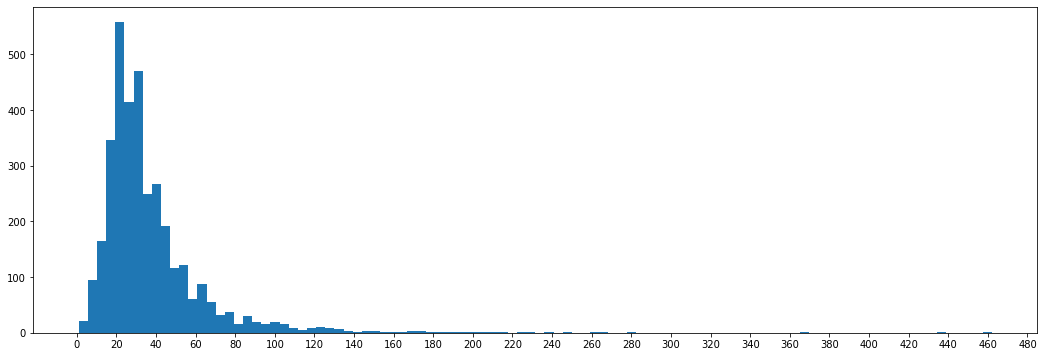

In [55]:
# Identificando a frêquencia dos comprimentos das sequência de treinamento
plt.figure(figsize=(18,6))
plt.hist(names, bins = 100)
x_ticks = np.arange(0, 500, 20)
plt.xticks(x_ticks)
plt.show()

Podemos ver claramente que a maioria das mensagens tem um comprimento de 60 palavras ou menos. 
Considerando que o comprimento máximo é 480. Portanto, se selecionarmos 480 como o comprimento de preenchimento, 
todas as sequências de entrada terão comprimento 480 e a maioria dos tokens nessas sequências serão tokens de preenchimento que 
não ajudarão o modelo a aprender nada útil e além disso, tornará o treinamento mais lento.

Portanto, definiremos 60 como o comprimento do preenchimento.

## Padding:

In [56]:
max_length = 60

padded_train = pad_sequences(sequences_train, maxlen=max_length, padding='post', truncating='post')

sequences_test = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(sequences_test, maxlen=max_length, padding='post', truncating='post')

### Sem Word Embeddings Pré-treinado:

In [57]:
embedding = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab, embedding, input_length=max_length))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 60, 16)            145520    
                                                                 
 dropout_3 (Dropout)         (None, 60, 16)            0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               74240     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 219,889
Trainable params: 219,889
Non-trainable params: 0
_________________________________________________________________


In [58]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[METRICS])

In [60]:
history = model.fit(padded_train,
          y_train,
          epochs=10,
          batch_size=32,
          validation_data=(padded_test, y_test))

Epoch 1/10
110/110 [==============================] - 7s 43ms/step - loss: 0.5448 - accuracy: 0.7740 - precision: 0.7762 - recall: 0.9959 - val_loss: 0.5313 - val_accuracy: 0.7760 - val_precision: 0.7760 - val_recall: 1.0000
Epoch 2/10
110/110 [==============================] - 4s 38ms/step - loss: 0.5296 - accuracy: 0.7760 - precision: 0.7760 - recall: 1.0000 - val_loss: 0.5290 - val_accuracy: 0.7760 - val_precision: 0.7760 - val_recall: 1.0000
Epoch 3/10
110/110 [==============================] - 4s 40ms/step - loss: 0.4353 - accuracy: 0.8111 - precision: 0.8176 - recall: 0.9739 - val_loss: 0.4198 - val_accuracy: 0.8353 - val_precision: 0.8837 - val_recall: 0.9072
Epoch 4/10
110/110 [==============================] - 6s 51ms/step - loss: 0.3289 - accuracy: 0.8700 - precision: 0.8927 - recall: 0.9462 - val_loss: 0.4027 - val_accuracy: 0.8447 - val_precision: 0.8674 - val_recall: 0.9442
Epoch 5/10
110/110 [==============================] - 5s 50ms/step - loss: 0.2581 - accuracy: 0.9074

In [61]:
loss, accuracy, precision, recall = model.evaluate(padded_test, y_test)

f1 = 2 * (precision * recall) / (precision + recall)

print("Acurácia: ", accuracy)

print("Precisão: ", precision)
print("F1-Score: ", f1)
print("Recall: ", recall)

47/47 [==============================] - 1s 18ms/step - loss: 0.6492 - accuracy: 0.8227 - precision: 0.8581 - recall: 0.9244
Acurácia:  0.8226666450500488
Precisão:  0.8580542206764221
F1-Score:  0.8899917142852704
Recall:  0.9243986010551453


## Criação dos Word Embeddings:

In [205]:
def is_float(s):
    try:
        float(s)
        return True
    except ValueError:
        return False


embeddings_index = {}

f = open('glove_s100.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    
    coefs = []
    for coef in values[1:]:
        if (is_float(coef)):
            coefs.append(coef)
    
    coefs = np.asarray(coefs, dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Foram encontrados %s vetores de palavras.' % len(embeddings_index))

Foram encontrados 929594 vetores de palavras.


In [206]:
# criação da matriz de embeddings
embedding_matrix = np.zeros((vocab, 100))


for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector[:100]

In [207]:
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Criando a Camada de Embbeding:

In [208]:
#Camada responsável para interpretar cada palavra para um embbeding:
import tensorflow
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(input_dim=vocab,
                            output_dim=100,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False) 

In [209]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

model = Sequential([
    embedding_layer,
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [210]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[METRICS])

In [211]:
history = model.fit(padded_train,
          y_train,
          batch_size = 32,
          epochs=10,
          validation_data=(padded_test, y_test))

Epoch 1/10
110/110 [==============================] - 4s 33ms/step - loss: 0.5148 - accuracy: 0.7757 - precision: 0.7761 - recall: 0.9993 - val_loss: 0.4748 - val_accuracy: 0.7753 - val_precision: 0.7759 - val_recall: 0.9991
Epoch 2/10
110/110 [==============================] - 3s 31ms/step - loss: 0.4248 - accuracy: 0.7900 - precision: 0.7914 - recall: 0.9904 - val_loss: 0.4470 - val_accuracy: 0.7940 - val_precision: 0.8008 - val_recall: 0.9777
Epoch 3/10
110/110 [==============================] - 3s 32ms/step - loss: 0.3381 - accuracy: 0.8417 - precision: 0.8458 - recall: 0.9735 - val_loss: 0.4413 - val_accuracy: 0.8040 - val_precision: 0.8103 - val_recall: 0.9759
Epoch 4/10
110/110 [==============================] - 3s 31ms/step - loss: 0.2249 - accuracy: 0.9300 - precision: 0.9306 - recall: 0.9831 - val_loss: 0.4909 - val_accuracy: 0.7627 - val_precision: 0.8755 - val_recall: 0.8093
Epoch 5/10
110/110 [==============================] - 3s 31ms/step - loss: 0.1347 - accuracy: 0.9723

In [212]:
loss, accuracy, precision, recall = model.evaluate(padded_test, y_test)

f1 = 2 * (precision * recall) / (precision + recall)

print("Acurácia: ", accuracy)

print("Precisão: ", precision)
print("F1-Score: ", f1)
print("Recall: ", recall)

47/47 [==============================] - 1s 11ms/step - loss: 0.6760 - accuracy: 0.8100 - precision: 0.8373 - recall: 0.9373
Acurácia:  0.8100000023841858
Precisão:  0.8372985124588013
F1-Score:  0.8844750639445604
Recall:  0.9372852444648743


## Ajuste de Paramêtros sem Word Embeddings Pré-treinado:

In [220]:
def model_to_optimize(num_filters, kernel_size):
    model = Sequential([
      Embedding(vocab, embedding, input_length=max_length),
      Conv1D(num_filters, kernel_size, activation='relu'),
      GlobalMaxPooling1D(),
      Dense(10, activation='relu'),
      Dense(1, activation='sigmoid')])
    
    METRICS = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ]

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[METRICS])

    return model

In [221]:
num_filters = [32, 64, 128]
kernel_size = [3, 5, 7]

params = {
    "num_filters": num_filters,
    "kernel_size": kernel_size,
}


In [222]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn=model_to_optimize,
                        epochs=10,
                        batch_size=10,
                        verbose=False
)

In [223]:
#Realizando o GridSearch:
from sklearn.model_selection import GridSearchCV
gridSearch = GridSearchCV(estimator=model, param_grid=params,
                              cv=5, verbose=1)
search_result = gridSearch.fit(padded_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [224]:
#Descobrindo a acurácia de teste:
test_accuracy = gridSearch.score(padded_test, y_test)
print(test_accuracy)
#Melhores parâmetros
gridSearch.best_params_

0.8140000104904175


{'kernel_size': 3, 'num_filters': 32}

In [225]:
model = Sequential([
    Embedding(vocab, embedding, input_length=max_length),
    Conv1D(gridSearch.best_params_['num_filters'], gridSearch.best_params_['kernel_size'], activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')])


METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[METRICS])

In [226]:
history = model.fit(padded_train,
          y_train,
          batch_size=32,
          epochs=10,
          validation_data=(padded_test, y_test))

Epoch 1/10
110/110 [==============================] - 2s 8ms/step - loss: 0.5939 - accuracy: 0.7220 - precision: 0.7729 - recall: 0.9087 - val_loss: 0.5268 - val_accuracy: 0.7760 - val_precision: 0.7760 - val_recall: 1.0000
Epoch 2/10
110/110 [==============================] - 1s 6ms/step - loss: 0.5086 - accuracy: 0.7760 - precision: 0.7760 - recall: 1.0000 - val_loss: 0.4878 - val_accuracy: 0.7760 - val_precision: 0.7760 - val_recall: 1.0000
Epoch 3/10
110/110 [==============================] - 1s 6ms/step - loss: 0.4294 - accuracy: 0.8006 - precision: 0.7996 - recall: 0.9915 - val_loss: 0.4058 - val_accuracy: 0.8173 - val_precision: 0.8248 - val_recall: 0.9708
Epoch 4/10
110/110 [==============================] - 1s 6ms/step - loss: 0.3303 - accuracy: 0.8586 - precision: 0.8688 - recall: 0.9632 - val_loss: 0.3881 - val_accuracy: 0.8200 - val_precision: 0.8341 - val_recall: 0.9588
Epoch 5/10
110/110 [==============================] - 1s 6ms/step - loss: 0.2553 - accuracy: 0.9031 - pr

In [227]:
loss, accuracy, precision, recall = model.evaluate(padded_test, y_test)

f1 = 2 * (precision * recall) / (precision + recall)

print("Acurácia: ", accuracy)

print("Precisão: ", precision)
print("F1-Score: ", f1)
print("Recall: ", recall)

47/47 [==============================] - 0s 2ms/step - loss: 0.5867 - accuracy: 0.8147 - precision: 0.8686 - recall: 0.8969
Acurácia:  0.8146666884422302
Precisão:  0.8685523867607117
F1-Score:  0.8825020969353264
Recall:  0.8969072103500366


## Ajuste de Paramêtros com Word Embeddings Pré-treinado:

In [228]:
def model_to_optimize(num_filters, kernel_size):
    model = Sequential([
      embedding_layer,
      Conv1D(num_filters, kernel_size, activation='relu'),
      GlobalMaxPooling1D(),
      Dense(10, activation='relu'),
      Dense(1, activation='sigmoid')])
    
    METRICS = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ]

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[METRICS])

    return model

In [229]:
num_filters = [32, 64, 128]
kernel_size = [3, 5, 7]

params = {
    "num_filters": num_filters,
    "kernel_size": kernel_size,
}

In [230]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn=model_to_optimize,
                        epochs=10,
                        batch_size=10,
                        verbose=False
)

In [231]:
#Realizando o GridSearch:
from sklearn.model_selection import GridSearchCV
gridSearch = GridSearchCV(estimator=model, param_grid=params,
                              cv=5, verbose=1)
search_result = gridSearch.fit(padded_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [232]:
#Descobrindo a acurácia de teste:
test_accuracy = gridSearch.score(padded_test, y_test)
print(test_accuracy)
#Melhores parâmetros
gridSearch.best_params_

0.8153333067893982


{'kernel_size': 5, 'num_filters': 128}

In [83]:
pd.DataFrame(gridSearch.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel_size,param_num_filters,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.399064,0.892032,0.536600,0.045889,3,32,"{'kernel_size': 3, 'num_filters': 32}",0.825714,0.784286,0.790000,0.804286,0.782857,0.797429,0.016046,9
1,10.565395,1.732574,0.528603,0.055957,3,64,"{'kernel_size': 3, 'num_filters': 64}",0.812857,0.814286,0.804286,0.822857,0.814286,0.813714,0.005897,3
2,13.943998,1.966088,0.569402,0.055117,3,128,"{'kernel_size': 3, 'num_filters': 128}",0.828571,0.817143,0.802857,0.825714,0.825714,0.820000,0.009390,1
3,11.107489,0.996155,0.555201,0.057073,5,32,"{'kernel_size': 5, 'num_filters': 32}",0.795714,0.797143,0.794286,0.802857,0.800000,0.798000,0.003077,8
4,13.598105,2.067557,0.546999,0.067733,5,64,"{'kernel_size': 5, 'num_filters': 64}",0.807143,0.805714,0.797143,0.801429,0.820000,0.806286,0.007698,6
5,19.151925,2.910826,0.623937,0.185752,5,128,"{'kernel_size': 5, 'num_filters': 128}",0.821429,0.817143,0.812857,0.815714,0.821429,0.817714,0.003332,2
6,14.254842,1.371457,0.483970,0.119997,7,32,"{'kernel_size': 7, 'num_filters': 32}",0.805714,0.807143,0.774286,0.811429,0.795714,0.798857,0.013322,7
7,21.316492,0.225467,0.483736,0.015529,7,64,"{'kernel_size': 7, 'num_filters': 64}",0.818571,0.804286,0.792857,0.822857,0.818571,0.811429,0.011212,5
8,27.499115,1.104443,0.546988,0.016912,7,128,"{'kernel_size': 7, 'num_filters': 128}",0.815714,0.812857,0.808571,0.814286,0.812857,0.812857,0.002390,4


In [233]:
model = Sequential([
    embedding_layer,
    Conv1D(gridSearch.best_params_['num_filters'], gridSearch.best_params_['kernel_size'], activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')])


METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[METRICS])

In [234]:
history = model.fit(padded_train,
          y_train,
          batch_size = 32,          
          epochs=10,
          validation_data=(padded_test, y_test))

Epoch 1/10
110/110 [==============================] - 4s 28ms/step - loss: 0.5025 - accuracy: 0.7786 - precision: 0.7827 - recall: 0.9893 - val_loss: 0.4559 - val_accuracy: 0.8040 - val_precision: 0.8081 - val_recall: 0.9802
Epoch 2/10
110/110 [==============================] - 3s 24ms/step - loss: 0.3702 - accuracy: 0.8389 - precision: 0.8377 - recall: 0.9827 - val_loss: 0.4367 - val_accuracy: 0.8127 - val_precision: 0.8254 - val_recall: 0.9622
Epoch 3/10
110/110 [==============================] - 3s 24ms/step - loss: 0.2732 - accuracy: 0.8983 - precision: 0.9041 - recall: 0.9720 - val_loss: 0.4484 - val_accuracy: 0.8067 - val_precision: 0.8457 - val_recall: 0.9184
Epoch 4/10
110/110 [==============================] - 3s 25ms/step - loss: 0.1554 - accuracy: 0.9631 - precision: 0.9628 - recall: 0.9908 - val_loss: 0.4910 - val_accuracy: 0.8040 - val_precision: 0.8241 - val_recall: 0.9502
Epoch 5/10
110/110 [==============================] - 3s 26ms/step - loss: 0.0701 - accuracy: 0.9940

In [86]:
loss, accuracy, precision, recall = model.evaluate(padded_test, y_test)

f1 = 2 * (precision * recall) / (precision + recall)

print("Acurácia: ", accuracy)

print("Precisão: ", precision)
print("F1-Score: ", f1)
print("Recall: ", recall)

47/47 [==============================] - 0s 5ms/step - loss: 0.3916 - accuracy: 0.8327 - precision: 0.8649 - recall: 0.9296
Acurácia:  0.8326666951179504
Precisão:  0.8649080991744995
F1-Score:  0.8960662690094189
Recall:  0.9295532703399658


## Com Stemming:

In [87]:
df_train, df_test = train_test_split(df, test_size = 0.30, random_state = 42, stratify=df["Review"])

print(df_train.shape, df_test.shape)

(3500, 7) (1500, 7)


In [121]:
X_train = df_train["Stemmer"]
y_train = df_train["Review"]

X_test = df_test["Stemmer"]
y_test = df_test["Review"]


tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Determina o tamanho do vocabulário
word_index = tokenizer.word_index
vocab = len(word_index) + 1
print("Tamanho do Vocabulário: ", vocab)

sequences_train = tokenizer.texts_to_sequences(X_train)

# Identificando o comprimento da maior sequência do conjunto de treinamento
names = [len(n) for n in sequences_train]
print("Comprimento da maior sequência: ", max(names))

Tamanho do Vocabulário:  4409
Comprimento da maior sequência:  462


Como as mensagens (texto) no conjunto de dados são de tamanho variável, usaremos o preenchimento para fazer com que todas as mensagens tenham o mesmo tamanho. Podemos usar o comprimento máximo da sequência para preencher as mensagens. No entanto, também podemos dar uma olhada na distribuição dos comprimentos de sequência no conjunto de treino para encontrar o comprimento de preenchimento correto.

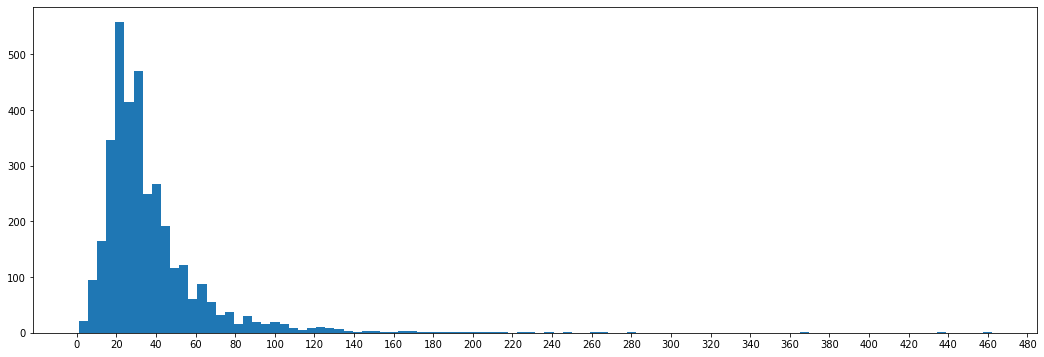

In [89]:
# Identificando a frêquencia dos comprimentos das sequências de treinamento
plt.figure(figsize=(18,6))
plt.hist(names, bins = 100)
x_ticks = np.arange(0, 500, 20)
plt.xticks(x_ticks)
plt.show()

Podemos ver claramente que a maioria das mensagens tem um comprimento de 60 palavras ou menos. Considerando que o comprimento máximo é 480. Portanto, se selecionarmos 480 como o comprimento de preenchimento, todas as sequências de entrada terão comprimento 480 e a maioria dos tokens nessas sequências serão tokens de preenchimento que não ajudarão o modelo a aprender nada útil e além disso, tornará o treinamento mais lento.

Portanto, definiremos 60 como o comprimento do preenchimento.

## Padding:

In [122]:
max_length = 60

padded_train = pad_sequences(sequences_train, maxlen=max_length, padding='post', truncating='post')

sequences_test = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(sequences_test, maxlen=max_length, padding='post', truncating='post')

### Sem Word Embeddings Pré-Treinado:

In [123]:
embedding = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab, embedding, input_length=max_length))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_195"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_102 (Embedding)   (None, 60, 16)            70544     
                                                                 
 dropout_5 (Dropout)         (None, 60, 16)            0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               74240     
                                                                 
 dense_385 (Dense)           (None, 1)                 129       
                                                                 
Total params: 144,913
Trainable params: 144,913
Non-trainable params: 0
_________________________________________________________________


In [124]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[METRICS])

In [125]:
history = model.fit(padded_train,
          y_train,
          epochs=10,
          batch_size=32,
          validation_data=(padded_test, y_test))

Epoch 1/10
110/110 [==============================] - 12s 90ms/step - loss: 0.5456 - accuracy: 0.7757 - precision: 0.7759 - recall: 0.9996 - val_loss: 0.5288 - val_accuracy: 0.7760 - val_precision: 0.7760 - val_recall: 1.0000
Epoch 2/10
110/110 [==============================] - 9s 84ms/step - loss: 0.4902 - accuracy: 0.7886 - precision: 0.8003 - recall: 0.9694 - val_loss: 0.4106 - val_accuracy: 0.8440 - val_precision: 0.8661 - val_recall: 0.9450
Epoch 3/10
110/110 [==============================] - 9s 85ms/step - loss: 0.3907 - accuracy: 0.8489 - precision: 0.8728 - recall: 0.9426 - val_loss: 0.3924 - val_accuracy: 0.8413 - val_precision: 0.8640 - val_recall: 0.9442
Epoch 4/10
110/110 [==============================] - 9s 86ms/step - loss: 0.3234 - accuracy: 0.8806 - precision: 0.8995 - recall: 0.9525 - val_loss: 0.4462 - val_accuracy: 0.8213 - val_precision: 0.8816 - val_recall: 0.8892
Epoch 5/10
110/110 [==============================] - 9s 85ms/step - loss: 0.2839 - accuracy: 0.896

In [126]:
loss, accuracy, precision, recall = model.evaluate(padded_test, y_test)

f1 = 2 * (precision * recall) / (precision + recall)

print("Acurácia: ", accuracy)

print("Precisão: ", precision)
print("F1-Score: ", f1)
print("Recall: ", recall)

47/47 [==============================] - 2s 35ms/step - loss: 0.5479 - accuracy: 0.8173 - precision: 0.8733 - recall: 0.8943
Acurácia:  0.8173333406448364
Precisão:  0.8733221292495728
F1-Score:  0.883701183234033
Recall:  0.8943299055099487


## Criação dos Word Embeddings:

In [127]:
def is_float(s):
    try:
        float(s)
        return True
    except ValueError:
        return False


embeddings_index = {}

f = open('glove_s100.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    
    coefs = []
    for coef in values[1:]:
        if (is_float(coef)):
            coefs.append(coef)
    
    coefs = np.asarray(coefs, dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Foram encontrados %s vetores de palavras.' % len(embeddings_index))

Foram encontrados 929594 vetores de palavras.


In [128]:
# criação da matriz de embeddings
embedding_matrix = np.zeros((vocab, 100))


for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector[:100]

In [129]:
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Criando a Camada de Embbeding:

In [130]:
#Camada responsável para interpretar cada palavra para um embbeding:
import tensorflow
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(input_dim=vocab,
                            output_dim=100,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False) 

In [131]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

model = Sequential([
    embedding_layer,
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [133]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[METRICS])

In [135]:
history = model.fit(padded_train,
          y_train,
          epochs=10,
          batch_size=32,
          validation_data=(padded_test, y_test))

Epoch 1/10
110/110 [==============================] - 3s 26ms/step - loss: 0.0577 - accuracy: 0.9971 - precision: 0.9963 - recall: 1.0000 - val_loss: 0.5095 - val_accuracy: 0.8100 - val_precision: 0.8347 - val_recall: 0.9416
Epoch 2/10
110/110 [==============================] - 3s 26ms/step - loss: 0.0252 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5896 - val_accuracy: 0.8160 - val_precision: 0.8284 - val_recall: 0.9622
Epoch 3/10
110/110 [==============================] - 3s 26ms/step - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6147 - val_accuracy: 0.8140 - val_precision: 0.8340 - val_recall: 0.9493
Epoch 4/10
110/110 [==============================] - 3s 26ms/step - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6292 - val_accuracy: 0.8140 - val_precision: 0.8360 - val_recall: 0.9459
Epoch 5/10
110/110 [==============================] - 3s 26ms/step - loss: 0.0040 - accuracy: 1.0000

In [136]:
loss, accuracy, precision, recall = model.evaluate(padded_test, y_test)

f1 = 2 * (precision * recall) / (precision + recall)

print("Acurácia: ", accuracy)

print("Precisão: ", precision)
print("F1-Score: ", f1)
print("Recall: ", recall)

47/47 [==============================] - 0s 9ms/step - loss: 0.7423 - accuracy: 0.8147 - precision: 0.8366 - recall: 0.9459
Acurácia:  0.8146666884422302
Precisão:  0.8366261124610901
F1-Score:  0.8879032155440323
Recall:  0.9458763003349304


## Ajuste de Paramêtros sem Word Embeddings Pré-treinado:

In [137]:
def model_to_optimize(num_filters, kernel_size):
    model = Sequential([
      Embedding(vocab, embedding, input_length=max_length),
      Conv1D(num_filters, kernel_size, activation='relu'),
      GlobalMaxPooling1D(),
      Dense(10, activation='relu'),
      Dense(1, activation='sigmoid')])
    
    METRICS = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ]

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[METRICS])

    return model

In [138]:
num_filters = [32, 64, 128]
kernel_size = [3, 5, 7]

params = {
    "num_filters": num_filters,
    "kernel_size": kernel_size,
}


In [140]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn=model_to_optimize,
                        epochs=10,
                        batch_size=10,
                        verbose=False
)

In [141]:
#Realizando o GridSearch:
from sklearn.model_selection import GridSearchCV
gridSearch = GridSearchCV(estimator=model, param_grid=params,
                              cv=5, verbose=1)
search_result = gridSearch.fit(padded_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [142]:
#Descobrindo a acurácia de teste:
test_accuracy = gridSearch.score(padded_test, y_test)
print(test_accuracy)
#Melhores parâmetros
gridSearch.best_params_

0.809333324432373


{'kernel_size': 3, 'num_filters': 32}

In [143]:
model = Sequential([
    Embedding(vocab, embedding, input_length=max_length),
    Conv1D(gridSearch.best_params_['num_filters'], gridSearch.best_params_['kernel_size'], activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')])


METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[METRICS])

In [144]:
history = model.fit(padded_train,
          y_train,
          epochs=5,
          validation_data=(padded_test, y_test))

Epoch 1/5
110/110 [==============================] - 2s 8ms/step - loss: 0.5478 - accuracy: 0.7760 - precision: 0.7760 - recall: 1.0000 - val_loss: 0.5103 - val_accuracy: 0.7760 - val_precision: 0.7760 - val_recall: 1.0000
Epoch 2/5
110/110 [==============================] - 1s 5ms/step - loss: 0.4886 - accuracy: 0.7760 - precision: 0.7760 - recall: 1.0000 - val_loss: 0.4751 - val_accuracy: 0.7760 - val_precision: 0.7760 - val_recall: 1.0000
Epoch 3/5
110/110 [==============================] - 1s 5ms/step - loss: 0.4216 - accuracy: 0.8011 - precision: 0.7988 - recall: 0.9941 - val_loss: 0.4246 - val_accuracy: 0.8080 - val_precision: 0.8059 - val_recall: 0.9914
Epoch 4/5
110/110 [==============================] - 1s 5ms/step - loss: 0.3341 - accuracy: 0.8666 - precision: 0.8674 - recall: 0.9775 - val_loss: 0.3935 - val_accuracy: 0.8340 - val_precision: 0.8555 - val_recall: 0.9459
Epoch 5/5
110/110 [==============================] - 1s 6ms/step - loss: 0.2513 - accuracy: 0.9074 - precisi

In [145]:
loss, accuracy, precision, recall = model.evaluate(padded_test, y_test)

f1 = 2 * (precision * recall) / (precision + recall)

print("Acurácia: ", accuracy)

print("Precisão: ", precision)
print("F1-Score: ", f1)
print("Recall: ", recall)

47/47 [==============================] - 0s 2ms/step - loss: 0.3958 - accuracy: 0.8247 - precision: 0.8618 - recall: 0.9218
Acurácia:  0.8246666789054871
Precisão:  0.8618474006652832
F1-Score:  0.8908260703463443
Recall:  0.9218212962150574


## Ajuste de Paramêtros com Word Embeddings Pré-treinado:

In [146]:
def model_to_optimize(num_filters, kernel_size):
    model = Sequential([
      embedding_layer,
      Conv1D(num_filters, kernel_size, activation='relu'),
      GlobalMaxPooling1D(),
      Dense(10, activation='relu'),
      Dense(1, activation='sigmoid')])
    
    METRICS = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ]

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[METRICS])

    return model

In [147]:
num_filters = [32, 64, 128]
kernel_size = [3, 5, 7]

params = {
    "num_filters": num_filters,
    "kernel_size": kernel_size,
}


In [157]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn=model_to_optimize,
                        epochs=10,
                        batch_size=32,
                        verbose=False
)

In [158]:
#Realizando o GridSearch:
from sklearn.model_selection import GridSearchCV
gridSearch = GridSearchCV(estimator=model, param_grid=params,
                              cv=5, verbose=1)
search_result = gridSearch.fit(padded_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [159]:
#Descobrindo a acurácia de teste:
test_accuracy = gridSearch.score(padded_test, y_test)
print(test_accuracy)
#Melhores parâmetros
gridSearch.best_params_

0.8046666383743286


{'kernel_size': 7, 'num_filters': 128}

In [160]:
pd.DataFrame(gridSearch.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel_size,param_num_filters,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.531836,0.711607,0.328754,0.017909,3,32,"{'kernel_size': 3, 'num_filters': 32}",0.784286,0.790000,0.777143,0.772857,0.771429,0.779143,0.007033,8
1,8.828713,0.934888,0.325986,0.006449,3,64,"{'kernel_size': 3, 'num_filters': 64}",0.784286,0.790000,0.785714,0.797143,0.792857,0.790000,0.004695,4
2,11.142655,0.861579,0.368998,0.000956,3,128,"{'kernel_size': 3, 'num_filters': 128}",0.818571,0.787143,0.788571,0.798571,0.782857,0.795143,0.012797,3
3,7.375367,0.624442,0.344025,0.019040,5,32,"{'kernel_size': 5, 'num_filters': 32}",0.788571,0.748571,0.785714,0.771429,0.790000,0.776857,0.015607,9
4,11.321693,0.857668,0.462188,0.108616,5,64,"{'kernel_size': 5, 'num_filters': 64}",0.798571,0.762857,0.785714,0.780000,0.790000,0.783429,0.011939,7
5,14.413961,1.769237,0.437479,0.015922,5,128,"{'kernel_size': 5, 'num_filters': 128}",0.808571,0.777143,0.797143,0.792857,0.805714,0.796286,0.011125,2
6,8.240844,0.713448,0.450842,0.133541,7,32,"{'kernel_size': 7, 'num_filters': 32}",0.778571,0.785714,0.784286,0.804286,0.767143,0.784000,0.012068,6
7,12.564625,1.033466,0.422121,0.011262,7,64,"{'kernel_size': 7, 'num_filters': 64}",0.782857,0.784286,0.797143,0.775714,0.784286,0.784857,0.006916,5
8,16.461017,1.833255,0.492817,0.026788,7,128,"{'kernel_size': 7, 'num_filters': 128}",0.807143,0.790000,0.790000,0.791429,0.812857,0.798286,0.009748,1


In [161]:
model = Sequential([
    embedding_layer,
    Conv1D(gridSearch.best_params_['num_filters'], gridSearch.best_params_['kernel_size'], activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')])


METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[METRICS])

In [162]:
history = model.fit(padded_train,
          y_train,
          epochs=10,
          batch_size=32,          
          validation_data=(padded_test, y_test))

Epoch 1/10
110/110 [==============================] - 4s 29ms/step - loss: 0.5305 - accuracy: 0.7743 - precision: 0.7758 - recall: 0.9974 - val_loss: 0.4996 - val_accuracy: 0.7760 - val_precision: 0.7760 - val_recall: 1.0000
Epoch 2/10
110/110 [==============================] - 3s 26ms/step - loss: 0.4472 - accuracy: 0.7760 - precision: 0.7760 - recall: 1.0000 - val_loss: 0.4575 - val_accuracy: 0.7760 - val_precision: 0.7760 - val_recall: 1.0000
Epoch 3/10
110/110 [==============================] - 3s 26ms/step - loss: 0.3586 - accuracy: 0.8040 - precision: 0.7996 - recall: 0.9974 - val_loss: 0.4387 - val_accuracy: 0.8033 - val_precision: 0.8119 - val_recall: 0.9716
Epoch 4/10
110/110 [==============================] - 2s 22ms/step - loss: 0.2277 - accuracy: 0.9257 - precision: 0.9285 - recall: 0.9797 - val_loss: 0.4426 - val_accuracy: 0.8120 - val_precision: 0.8478 - val_recall: 0.9235
Epoch 5/10
110/110 [==============================] - 3s 23ms/step - loss: 0.0935 - accuracy: 0.9883

In [163]:
loss, accuracy, precision, recall = model.evaluate(padded_test, y_test)

f1 = 2 * (precision * recall) / (precision + recall)

print("Acurácia: ", accuracy)

print("Precisão: ", precision)
print("F1-Score: ", f1)
print("Recall: ", recall)

47/47 [==============================] - 0s 9ms/step - loss: 0.6310 - accuracy: 0.8120 - precision: 0.8331 - recall: 0.9476
Acurácia:  0.8119999766349792
Precisão:  0.8330815434455872
F1-Score:  0.8866559424530698
Recall:  0.9475945234298706
